In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import wget, os
from astropy.io import fits

from tatpulsar.data.profile import draw_random_pulse

mpl.rcParams['figure.dpi'] = 250
plt.style.use(['science', 'nature', 'no-latex'])

np.random.seed(19930727)

In [8]:
profile_init = draw_random_pulse(nbins=200, baseline=100000, pulsefrac=0.5)

nphot = 2000 # Number of photons to draw
tstart = 59000 # Start time of simulated event list
tstop  = 60000 # Stop time of simulated event list
f0 = 29.639378
# f1 = par.f1
# f2 = par.f2

pepoch = 57981


event_list = profile_init.sampling_event(nphot=nphot,
                                             tstart=tstart,
                                             tstop=tstop,
                                             f0=f0,
                                             pepoch=pepoch)

100%|██████████████████████████████████████████████████████████████████████████| 995/995 [00:00<00:00, 233447.03it/s]


In [9]:
def solve_kepler(M, e, tolerance=1e-6, max_iterations=1000):
    """
    Solve Kepler's equation using the Newton-Raphson method.

    Parameters
    ----------
    M : float
        The mean anomaly.
    e : float
        The eccentricity of the orbit.
    tolerance : float, optional
        The desired accuracy. The iteration stops when the change is below this threshold.
    max_iterations : int, optional
        The maximum number of iterations. The iteration stops when this number is reached.

    Returns
    -------
    E : float
        The eccentric anomaly.
    """
    # Start with an initial guess
    if M < np.pi:
        E = M + e / 2
    else:
        E = M - e / 2

    # Perform the Newton-Raphson iteration
    for _ in range(max_iterations):
        delta_E = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))

        # If the change is small enough, stop
        if abs(delta_E) < tolerance:
            break

        E -= delta_E

    return E

In [15]:
# These are placeholders; replace them with your actual values
observed_times = event_list 

fake_axsini = 200
fake_Porb   = 100 #days
fake_omega = 1.5*np.pi
fake_e = 0.05
fake_T_halfpi = 58540

T0 = fake_T_halfpi  # time of periastron passage
P = fake_Porb  # orbital period
e = fake_e  # eccentricity
w = fake_omega  # longitude of periastron
a = fake_axsini  # semi-major axis
i = np.pi / 2  # inclination of the orbit

# Compute mean anomalies
M = 2 * np.pi * (observed_times - T0) / P

# Solve Kepler's equation for eccentric anomalies
solve_kepler_vec = np.vectorize(solve_kepler)
E = solve_kepler_vec(M, e)

# Compute true anomalies
f = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))

# Compute Roemer delays
c = 299792.458 #3e5  # speed of light in km/s
delta_t = a * np.sin(i) * (np.cos(w + f) + e * np.cos(w)) / c

# Compute emission times
emission_times = observed_times + delta_t

<ErrorbarContainer object of 3 artists>

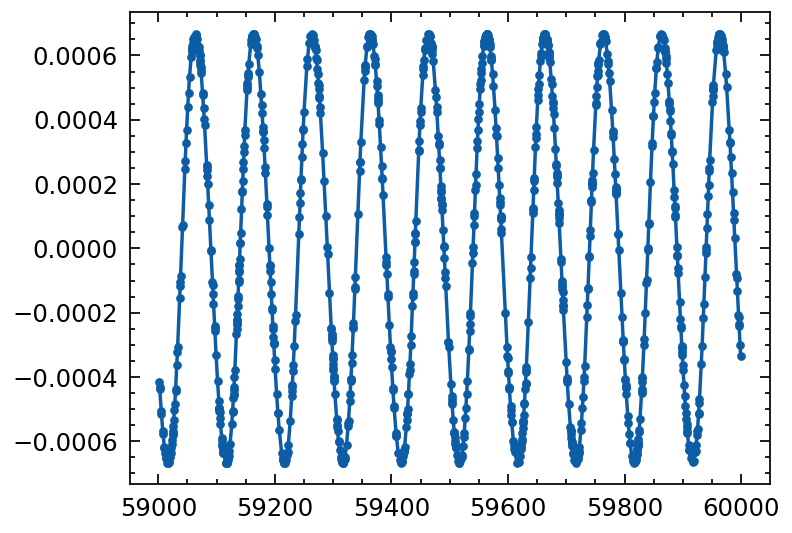

In [16]:
sort_mask = np.argsort(observed_times)
plt.errorbar(observed_times[sort_mask], delta_t[sort_mask], fmt='.-')